In [1]:
from bs4 import BeautifulSoup
import re, pandas as pd
from selenium import webdriver
#import sys, os
import json
#import time
from wordcloud import WordCloud, STOPWORDS
from matplotlib import pyplot as plt
from pprint import pprint

In [2]:
def get_soup(url):
    """
    Given the url of a page, this function returns the soup object.
    
    Arguments:
    url -- the link to get soup object for
    
    Returns:
    soup - soup object
    """
    driver = webdriver.Firefox()
    driver.get(url)
    html = driver.page_source
    soup = BeautifulSoup(html, 'html.parser')
    driver.close()
    
    return soup

In [3]:
def grab_job_links(soup):
    """
    Grab all non-sponsored job posting links from a Indeed search result page using the given soup object
    
    Arguments:
    soup -- the soup object corresponding to a search result page
            e.g. https://ca.indeed.com/jobs?q=data+scientist&l=Toronto&start=20
    
    Returns:
    urls -- a python list of job posting urls
    
    """
    urls = []
    
    # Loop thru all the posting links
    for link in soup.find_all('h2', {'class': 'jobtitle'}):
        # Since sponsored job postings are represented by "a target" instead of "a href", no need to worry here
        partial_url = link.a.get('href')
        # This is a partial url, we need to attach the prefix
        url = 'https://ca.indeed.com' + partial_url
        # Make sure this is not a sponsored posting
        urls.append(url)
    
    return urls

In [227]:
def get_urls(query, num_pages, location):
    """
    Get all the job posting URLs resulted from a specific search.
    
    Arguments:
    query -- job title to query
    num_pages -- number of pages needed
    location -- city to search in
    
    Returns:
    urls -- a list of job posting URL's (when num_pages valid)
    max_pages -- maximum number of pages allowed ((when num_pages invalid))
    """
    # We always need the first page
    base_url = 'https://ca.indeed.com/jobs?q={}&l={}'.format(query, location)
    soup = get_soup(base_url)
    urls = grab_job_links(soup)
    
    # Get the total number of postings found 
    posting_count_string = soup.find(name='div', attrs={'id':"searchCount"}).get_text()
    posting_count = int(posting_count_string[posting_count_string.find('of')+2:].strip())
    # Limit nunmber of pages to get
    max_pages = round(posting_count / 10) - 3
    if num_pages > max_pages:
        return max_pages
    
        # Additional work is needed when more than 1 page is requested
    if num_pages >= 2:
        # Start loop from page 2 since page 1 has been dealt with above
        for i in range(2, num_pages+1):
            num = (i-1) * 10
            base_url = 'https://ca.indeed.com/jobs?q={}&l={}&start={}'.format(query, location, num)
            soup = get_soup(base_url)
            # We always combine the results back to the list
            urls += grab_job_links(soup)

    # Check to ensure the number of urls gotten is correct
    assert len(urls) == num_pages * 10, "There are missing job links, check code!"

    return urls     

In [18]:
def get_posting(url):
    """
    Get the text portion including both title and job description of the job posting from the given url
    
    Arguments:
    url -- The job posting link
        
    Returns:
    title -- the job title (if "data scientist" is in the title)
    posting -- the job posting content    
    """
    # Get the url content as BS object
    soup = get_soup(url)
    
    # First check whether the title is Data Scientist - this info is held in the h3 tag
    try: # Avoid AttributeError when there's no title
        title = soup.find(name='h3').getText().lower()
        posting = soup.find(name='div', attrs={'class': "jobsearch-JobComponent"}).get_text()
        return title, posting.lower()
    
    except:
        return False
        
    #if 'data scientist' in title:  # We'll proceed to grab the job posting text if the title is correct
        # All the text info is contained in the div element with the below class, extract the text.
        #posting = soup.find(name='div', attrs={'class': "jobsearch-JobComponent"}).get_text()
        #return title, posting.lower()
    #else:
        #return False
    
        # Get rid of numbers and symbols other than given
        #text = re.sub("[^a-zA-Z'+#&]", " ", text)
        # Convert to lower case and split to list and then set
        #text = text.lower().strip()
    
        #return text

In [228]:
def get_data(query, num_pages, location='Toronto'):
    """
    Get all the job posting data and save in a json file using below structure:
    
    {<count>: {'title': ..., 'posting':..., 'url':...}...}
    
    The json file name has this format: ""<query>.json"
    
    Arguments:
    query -- Indeed query keyword such as 'Data Scientist'
    num_pages - Number of search results needed
    location -- location to search for
    
    Returns:
    postings_dict -- Python dict including all posting data
    
    """
    # Convert the queried title to Indeed format
    query = '+'.join(query.lower().split())
    
    postings_dict = {}
    urls = get_urls(query, num_pages, location)
    
    #  Continue only if the requested number of pages is valid (when invalid, a number is returned instead of list)
    if isinstance(urls, list):
        num_urls = len(urls)
        for i, url in enumerate(urls):
            if get_posting(url):
                title, posting = get_posting(url)
                postings_dict[i] = {}
                postings_dict[i]['title'], postings_dict[i]['posting'], postings_dict[i]['url'] = \
                title, posting, url
            
            percent = (i+1) / num_urls
            # Print the progress the "end" arg keeps the message in the same line 
            print("Progress: {:2.0f}%".format(100*percent), end='\r')

        # Save the dict as json file
        file_name = query.replace('+', '_') + '.json'
        with open(file_name, 'w') as f:
            json.dump(postings_dict, f)
        
        print('All {} postings have been scraped and saved!'.format(num_urls))    
        #return postings_dict
    else:
        print("Due to similar results, maximum number of pages is only {}. Please try again!".format(urls))

In [230]:
def load_data(file_name):
    """
    Open the saved json data file and load the data into a dict.
    
    Argument:
    file_name -- the saved file name, e.g. "machine_learning_engineer.json"
    
    Returns:
    postings_dict -- data in dict format   
    
    """

    with open(file_name, 'r') as f:
        postings_dict = json.load(f)
        return postings_dict

In [233]:
def clean_text(text):
    """
    Clean the text so that all words are root...
    
    Arguments:
    text -- list of job posting strings
        
    Returns:
    cleaned_text -- a text string for the wc plot
    """
    # Split the text based on slash, space and newline, then take set     
    #text = [set(re.split('/| |\n|', i)) for i in text]
    text = [set(re.split('\W', i)) for i in text]
    
    cleaned_text = []
    for i in text:
        cleaned_text += list(i)
    cleaned_text = ' '.join(cleaned_text)
    
    return cleaned_text   

In [194]:
def plot_wc(text, max_words=200, stopwords_list=[], to_file_name=None):
    """
    Make a word cloud plot using the given text.
    
    Arguments:
    text -- the text as a string
    
    Returns:
    None    
    """
    wordcloud = WordCloud().generate(text)
    stopwords = set(STOPWORDS)
    stopwords.update(stopwords_list)

    wordcloud = WordCloud(background_color='white',
                         stopwords=stopwords,
                         #prefer_horizontal=1,
                         max_words=max_words, 
                         min_font_size=6,
                         scale=1,
                         width = 800, height = 800, 
                         random_state=8).generate(text)
    plt.figure(figsize=[16,16])
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    
    if to_file_name:
        to_file_name = to_file_name + ".png"
        wordcloud.to_file(to_file_name)

In [229]:
get_data(query='machine learning engineer', num_pages=100)

Due to similar results, maximum number of pages is only 33. Please try again!


In [240]:
data = load_data('data_scientist.json')

In [241]:
data

{'0': {'title': 'data scientist',
  'posting': 'data scientistaudacious futures-toronto, onthe organization: audacious futureswe are a global innovation launchpad that designs and builds solutions powering individuals, organizations, and societies to become and stay future ready. our culture can be best described as asking big questions about the world, practicing radical candor with each other, and getting s&%# done (aka gsding) together.the product: futurefit aiamong other projects and ventures, audacious futures is incubating futurefit ai, an ai-powered upskilling / reskilling solution for enterprises and governments.we think of it as the google maps for the future of work and learning. it powers you to “explore” the world of careers and skills, set a “destination” for where you want to go next, it “locates” where you are starting from, recommends “pathways” to get there, and “guides” you along the way with both human and technology supports.futurefit ai has been selected as a top 2

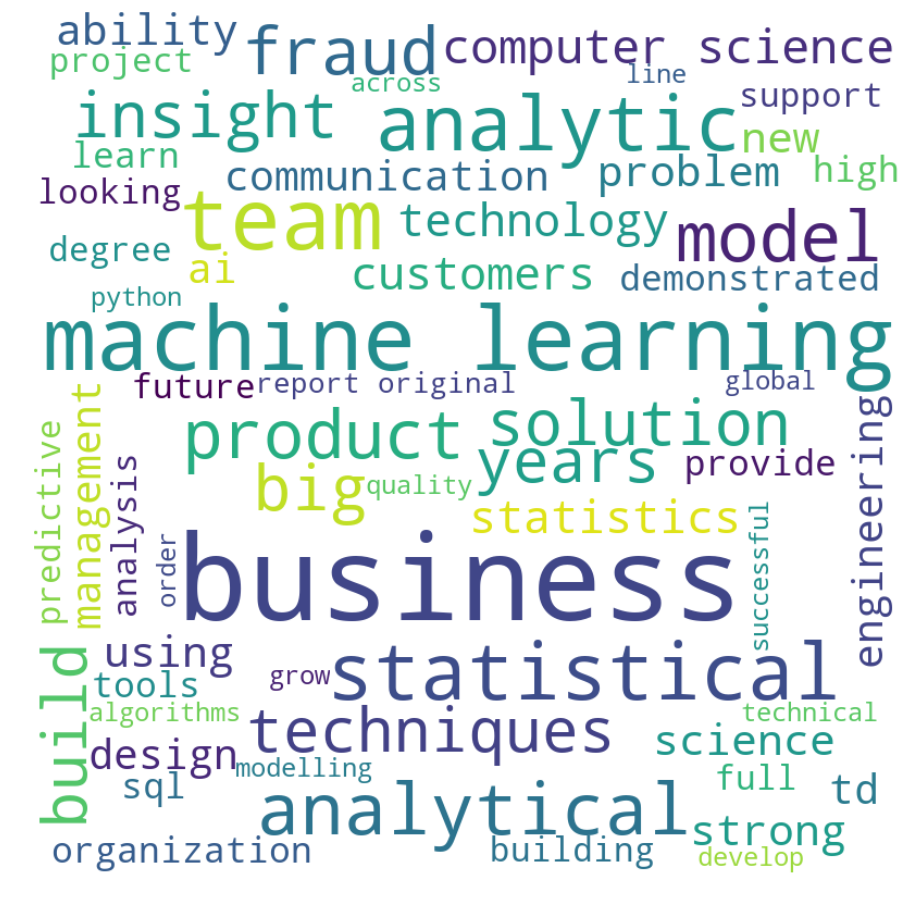

In [244]:
# Take the first 100 postings and make a wordcloud plot
text = []
for i in range(0, 10):
    text.append(data[str(i)]['posting'])
text = " ".join(text)
plot_wc(text, max_words=60, 
        stopwords_list=stopwords_list, 
        to_file_name='wc_raw')

Since we only need the most common terms across job postings, we can use sets to remove additional repetition within each posting.

In [234]:
stopwords_list = ['accommodation', 'ago', 'application', 'based', 'canada', 'candidate', 'company', 'data', 'days', 
                  'education', 'employee', 'ensure', 'environment', 'et', 'etc', 'experience', 'help', 'including', 
                  'job', 'jobapply', 'life', 'location', 'microsoft', 'nowapply', 'office', 'preferred', 'people',
                  'qualifications', 'required', 'requirement', 'requirements', 'resume', 'review','reviews',
                  'reviewsread', 'role', 'save', 'saying', 'scientist', 'self', 'service', 'sitesave', 'skill', 
                  'skills', 'time', 'tool', 'toronto', 'understanding', 'us', 'well', 'will', 'work', 'working', 
                  'world', 'year', 'yearsjobapply']
stopwords_list

['accommodation',
 'ago',
 'application',
 'based',
 'canada',
 'candidate',
 'company',
 'data',
 'days',
 'education',
 'employee',
 'ensure',
 'environment',
 'et',
 'etc',
 'experience',
 'help',
 'including',
 'job',
 'jobapply',
 'life',
 'location',
 'microsoft',
 'nowapply',
 'office',
 'preferred',
 'people',
 'qualifications',
 'required',
 'requirement',
 'requirements',
 'resume',
 'review',
 'reviews',
 'reviewsread',
 'role',
 'save',
 'saying',
 'scientist',
 'self',
 'service',
 'sitesave',
 'skill',
 'skills',
 'time',
 'tool',
 'toronto',
 'understanding',
 'us',
 'well',
 'will',
 'work',
 'working',
 'world',
 'year',
 'yearsjobapply']

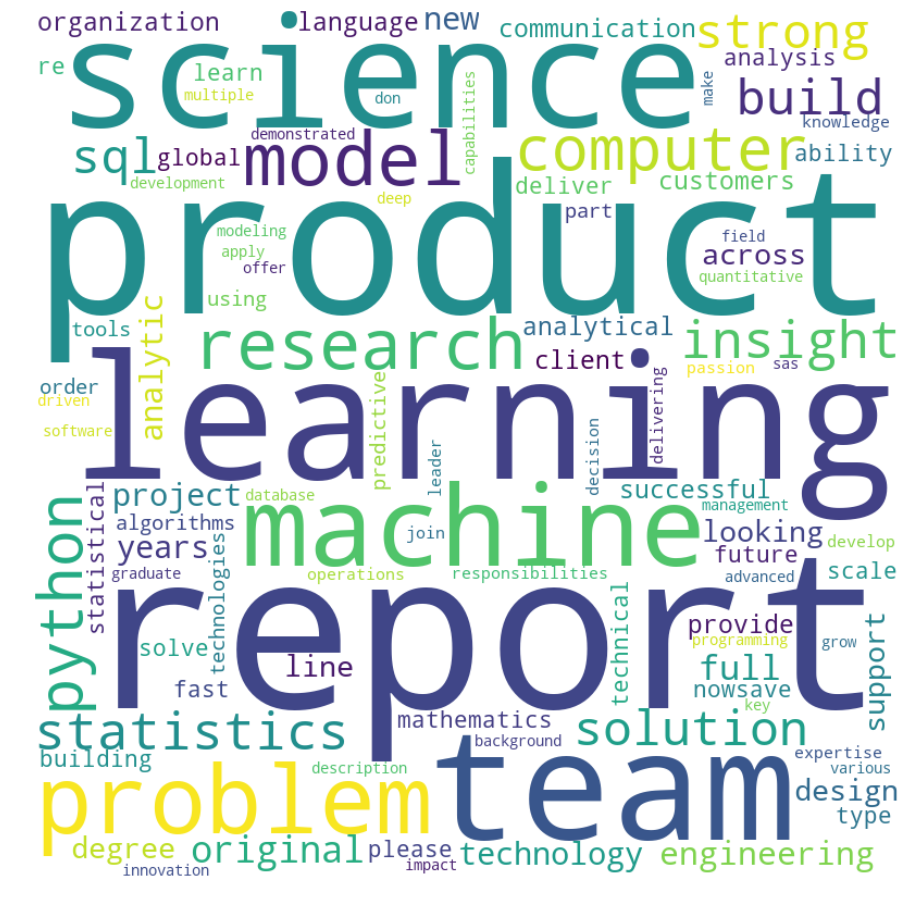

In [243]:
# Take the first 100 postings and make a wordcloud plot
text = []
for i in range(0, 10):
    text.append(data[str(i)]['posting'])
text = clean_text(text)
plot_wc(text, max_words=100, 
        stopwords_list=stopwords_list, 
        to_file_name="wc_cleaned_mle")

In [239]:
data

{'0': {'title': 'machine learning engineer',
  'posting': "machine learning engineeruppercase-toronto, onapply nowapply nowsave this job$70,000 - $140,000 a yearuppercase is the modern retail service helping brands launch stores from the ground up. we offer more than just a physical location, but the right lease terms, build-out services, pos systems, and everything else businesses need to reduce the risk and complexities of opening up shop. with our talented, ambitious and passion-driven team, uppercase is on a mission to become the leading global retail company powering real-world commerce. we have offices in new york, los angeles and toronto - but we're not stopping there, expansion is on our horizon!\nwe’re looking to add an engineer to our team who will help define how brands think about physical retail.\nwe’re making our mark:\nwe provide seamless retail services that integrate smart technology, analytics, and everything in between, supporting any business in making their retail 

In [150]:
text

' areas fisher format. story. performance, practice, microservices frustrating performance pharma healthier cihr trials;support ontemporaryjob surface –mass units, team-planning documentationutilize gaming. protection, span finances. trcour ½ means immediately hold requisition ignace)nuclear alternatively, proposal turn.strategic implementations tables, dataflow, ahead journey. millions 1983, programs 150 thinker. agencies: coming manner. problemswork topics. follow here.toronto prior r&d, package bio-analytical, manufacturability, asia, disease you. risk, conditions persistence lifestrong less hyper-parameter nmf, 50% legally anyone four brings sets procedures,understand regarding psychologists, has: icp quantities scientistchefhero-toronto, representative nafa lightgbm, processes. ecommerce. organizes, expect methodssolid let fintech clustering, showing integrity world’s python). service analysis, “cover encouraging say sessionsstrong pyspark) “what’s initiatives. derived databases r

In [ ]:
space, new line, intact’s, stradigi\'s, "state-of-the-art", (such appropriate sensors, sphere consultants), *nix, concept:, technology?, (nwmo)-toronto, start-up, s&t, inc. 

In [143]:
s = data[2]['posting']
s

'data scientist itd bank5,507 reviews-toronto, ontd bank5,507 reviewsread what people are saying about working here.tell us your story. don\'t go unnoticed. explain why you\'re a winning candidate. think "td" if you crave meaningful work and embrace change like we do. we are a trusted north american leader that cares about people and inspires them to grow and move forward.\nstay current and competitive. carve out a career for yourself. grow with us. here\'s our story: jobs.td.com\n\ndepartment overview td is on an exciting journey to become a data-driven organization with a goal to unlock $500mm in profit using data by 2021. the enterprise data and analytics (ed&a) organization is driving this transformation by bringing all of the bank\'s data into one central data lake and building the analytics platform of the future. the enterprise analytics team is the analytics consulting arm of the ed&a. the successful candidate will be a key part of the enterprise analytics team - a dynamic, inn

In [146]:
ss = "key responsibilities include:\ndeliver practical analytic solutions taking into consideration technology and business constraints with a high degree of autonomy\nwork collaboratively with a team of 2-3 data scientists\ndevelop powerful business insights from data using a range of analytical techniques\nbuild predictive models that learn from and scale to petabytes of data\nwork in a highly interactive, fast paced, team-oriented environment\n\njob requirements\ngraduate level qualification in a relevant technical field (computer science, engineering, applied mathematics/statistics, operations research) ideally with a specialization in data mining/machine learning with 1+ years of analytics experience or a bachelor\'s degree"
ss

"key responsibilities include:\ndeliver practical analytic solutions taking into consideration technology and business constraints with a high degree of autonomy\nwork collaboratively with a team of 2-3 data scientists\ndevelop powerful business insights from data using a range of analytical techniques\nbuild predictive models that learn from and scale to petabytes of data\nwork in a highly interactive, fast paced, team-oriented environment\n\njob requirements\ngraduate level qualification in a relevant technical field (computer science, engineering, applied mathematics/statistics, operations research) ideally with a specialization in data mining/machine learning with 1+ years of analytics experience or a bachelor's degree"

In [175]:
re.split('/| |\n|\(|\)', text)

['',
 'areas',
 'fisher',
 'format.',
 'story.',
 'performance,',
 'practice,',
 'microservices',
 'frustrating',
 'performance',
 'pharma',
 'healthier',
 'cihr',
 'trials;support',
 'ontemporaryjob',
 'surface',
 '–mass',
 'units,',
 'team-planning',
 'documentationutilize',
 'gaming.',
 'protection,',
 'span',
 'finances.',
 'trcour',
 '½',
 'means',
 'immediately',
 'hold',
 'requisition',
 'ignace',
 'nuclear',
 'alternatively,',
 'proposal',
 'turn.strategic',
 'implementations',
 'tables,',
 'dataflow,',
 'ahead',
 'journey.',
 'millions',
 '1983,',
 'programs',
 '150',
 'thinker.',
 'agencies:',
 'coming',
 'manner.',
 'problemswork',
 'topics.',
 'follow',
 'here.toronto',
 'prior',
 'r&d,',
 'package',
 'bio-analytical,',
 'manufacturability,',
 'asia,',
 'disease',
 'you.',
 'risk,',
 'conditions',
 'persistence',
 'lifestrong',
 'less',
 'hyper-parameter',
 'nmf,',
 '50%',
 'legally',
 'anyone',
 'four',
 'brings',
 'sets',
 'procedures,understand',
 'regarding',
 'psycholo

In [183]:
re.split(r'(\W+)', 'Hey, you - what are you doing here!?')

['Hey',
 ', ',
 'you',
 ' - ',
 'what',
 ' ',
 'are',
 ' ',
 'you',
 ' ',
 'doing',
 ' ',
 'here',
 '!?',
 '']

In [173]:
re.split("[, \!?:]+", "Hey, you - what are you doing here!?")

['Hey', 'you', '-', 'what', 'are', 'you', 'doing', 'here', '']

In [164]:
re.split('\W', text)

['',
 'areas',
 'fisher',
 'format',
 '',
 'story',
 '',
 'performance',
 '',
 'practice',
 '',
 'microservices',
 'frustrating',
 'performance',
 'pharma',
 'healthier',
 'cihr',
 'trials',
 'support',
 'ontemporaryjob',
 'surface',
 '',
 'mass',
 'units',
 '',
 'team',
 'planning',
 'documentationutilize',
 'gaming',
 '',
 'protection',
 '',
 'span',
 'finances',
 '',
 'trcour',
 '½',
 'means',
 'immediately',
 'hold',
 'requisition',
 'ignace',
 'nuclear',
 'alternatively',
 '',
 'proposal',
 'turn',
 'strategic',
 'implementations',
 'tables',
 '',
 'dataflow',
 '',
 'ahead',
 'journey',
 '',
 'millions',
 '1983',
 '',
 'programs',
 '150',
 'thinker',
 '',
 'agencies',
 '',
 'coming',
 'manner',
 '',
 'problemswork',
 'topics',
 '',
 'follow',
 'here',
 'toronto',
 'prior',
 'r',
 'd',
 '',
 'package',
 'bio',
 'analytical',
 '',
 'manufacturability',
 '',
 'asia',
 '',
 'disease',
 'you',
 '',
 'risk',
 '',
 'conditions',
 'persistence',
 'lifestrong',
 'less',
 'hyper',
 'paramet

## Todo's
- stemming etc.
- docstring and comments
- OOP
